### Importing Libraries

In [35]:
# importing libraries
import numpy as np
import scipy
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline
import IPython.display 
import librosa
import librosa.display
import essentia
import essentia.standard as es
np.set_printoptions(threshold='nan')
from pyswarm import pso

### Import multi-track, generate STFT matrix

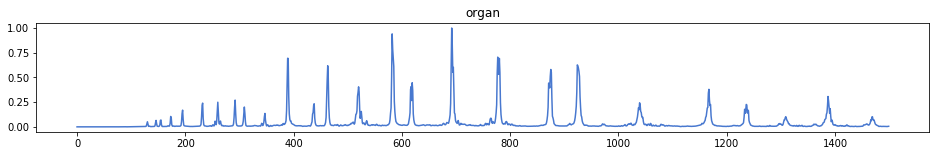

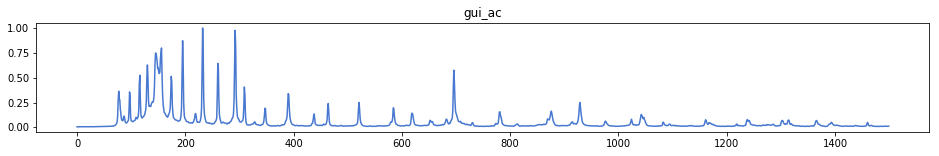

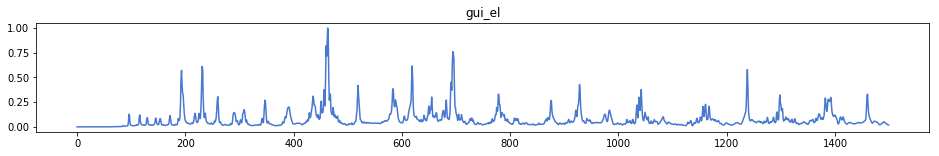

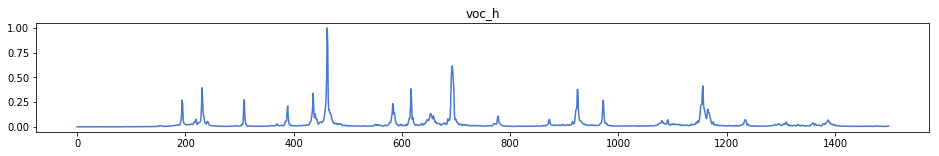

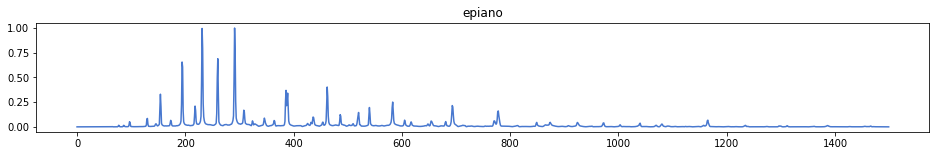

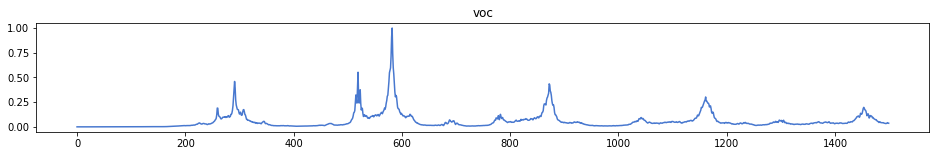

In [36]:
# initialising STFT params
sr = 44100.0
N = 2**15 #FFT size = 32768
M = N     #window size 
H = M/64  #hop size
W = np.hanning(M)

#tracks to extract, unpan track to the end
# tracks = ['piano', 'gui_ac','gui_el','cello','voc_h','voc','drum','bass']
tracks = ['organ', 'gui_ac','gui_el','voc_h','epiano','voc']


# initialising arrays needed
# track = [[],[],[],[],[],[],[],[]]
# stft = [[],[],[],[],[],[],[],[]]
# mx = [[],[],[],[],[],[],[],[]]
# px = [[],[],[],[],[],[],[],[]]
# spec_avg = [[],[],[],[],[],[],[],[]]

track = [[],[],[],[],[],[]]
stft = [[],[],[],[],[],[]]
mx = [[],[],[],[],[],[]]
px = [[],[],[],[],[],[]]
spec_avg = [[],[],[],[],[],[]]
indend = 1500# N/2+1
numpan = 5
for t in range(0,len(tracks)):
    track[t],sr = librosa.load('../samples/phrases2c/'+tracks[t]+'.wav', sr = sr, mono = 'True')
    stft[t] = librosa.stft(y = track[t], n_fft = N,win_length=M, hop_length=H, window = 'hann')   
    mx[t], px[t] = librosa.magphase(stft[t])
    mx[t] =  mx[t] / np.sum(W) #normlaising STFT output
    spec_avg[t] = np.average(mx[t],axis=1) 
    spec_avg[t] = spec_avg[t]/np.max(spec_avg[t])
    plt.figure(figsize=(16,2))
    plt.plot(spec_avg[t][0:indend])
    plt.title(tracks[t])
    plt.show()

### Metrics

In [30]:
def coh(mx, my):
    return np.multiply(mx,my)
def simfn(s1,s2):
    return np.average(2.0 * np.divide (np.abs(coh(s1,s2)) , np.add(coh(s1,s1),coh(s2,s2)) ))
def smfn(s1,s2):
    return np.sum(np.square(s1)-np.square(s2))
def smbfn(s1,s2):
    return np.sum(np.clip(np.sign(np.square(s1) - np.square(s2)),0,1))

print "Before\n"
for i in range(0,numpan):
    s = mx[i]/ np.sum(W)
    mix = np.sum(mx,0)/ np.sum(W)
    sm = smfn(s,mix-s)
    smb = smbfn(s,mix-s)
    print tracks[i],'\t', sm,'\t', smb

Before

organ 	-9.1135156e-08 	55550.0
gui_ac 	-7.1531645e-08 	7346623.0
gui_el 	-8.4283954e-08 	419441.0
voc_h 	-8.6677204e-08 	1625899.0
epiano 	-9.838992e-08 	15254.0


### Optimiser

In [31]:
fact = -0.007
n = N/2 + 1
print n
freqs = np.linspace(20,20000,n)
x_mels = 2595 * np.log10(1 + (freq)/700)

#       f,freq,order,shift,start,attn,s
factor =[1.0,0.7,0.8,0.9,1.2]
order = [0.01,0.01,0.01,0.01,0.01]
shift = [100,-200,-400,-50,50]
start = [200,200,600,200,400]
attn =  [1.0,1.0,1.0,1.0,1.0]
s =     [0,200,100,50,0]
pf = [[],[],[],[],[]]
myL = np.copy(mx)
myR = np.copy(mx)

def env(x,k,a,b):
    envelope = k * 1/(1+np.exp(a+b*x))
    return envelope 

def panpso(arg):
    
    for i in range(0,numpan):
        print i*6+5
        factor[i],order[i],shift[i],start[i],attn[i],s[i] = arg[i*6+0],arg[i*6+1],arg[i*6+2],arg[i*6+3],arg[i*6+4],arg[i*6+5]
    
        st = int(start[i])
        stop  = n
        freq = freqs * factor[i]
        mels = order[i] * 2595 * np.log10(1 + (freq+shift[i])/700) #/700 acc to formula

        l1_start,l1_stop = 1.0,1.0
        l2_start,l2_stop = 1.0,1.0

        wave = np.zeros(n)
        bins = np.arange(0,n)
        x_bins = np.arange(0,stop-st)
        envelope = offset+env(bins,1.0+attn[i],st/100, fact)
        envelope = envelope/np.max(envelope)
        wave[st:stop] = np.sin(mels[st:stop])
        line1 = ((bins-stop)*(l1_stop-l1_start))/(stop-st)+l1_stop
        line2 = ((bins-stop)*(l2_stop-l2_start))/(stop-st)+l2_stop
        pf[i] = (envelope*wave*line1*line2 + 1.0)/2.0
        pf[i] = scipy.ndimage.shift(pf[i], shift[i], output=None, order=3, mode='mirror', cval=0.5, prefilter=True)
        pf[i] = scipy.ndimage.shift(pf[i], s[i], output=None, order=3, mode='constant', cval=0.5, prefilter=True)
        
        if (i%2):
            myL[i] = np.transpose(np.transpose(myL[i])*np.matlib.repmat(pf[i], np.size(stft[0],axis=1),1))
            myR[i] = np.transpose(np.transpose(myR[i])*np.matlib.repmat((-1.0*pf[i])+1.0, np.size(stft[0],axis=1),1))
        else:
            myR[i] = np.transpose(np.transpose(myR[i])*np.matlib.repmat(pf[i], np.size(stft[0],axis=1),1))
            myL[i] = np.transpose(np.transpose(myL[i])*np.matlib.repmat((-1.0*pf[i])+1.0, np.size(stft[0],axis=1),1))
        

        
    myLt, myRt = myL[0],myR[0]
    
    for i in range(1,numpan):
        myLt = myLt + myL[i]
        myRt = myRt + myR[i] 
        
    a1, a2 = np.average(myLt,axis=1),np.average(myRt,axis=1)    
        
    
    return simfn(a1,a2) 

from pyswarm import pso

lb = [0.7,0.008,-400,200,0.0,0,    0.7,0.008,-400,200,0.0,0,    0.7,0.008,-400,200,0.0,0,   0.7,0.008,-400,200,0.0,0,   0.7,0.008,-400,200,0.0,0  ]
ub = [1.2,0.012, 100,600,1.0,200,  1.2,0.012, 100,600,1.0,200,  1.2,0.012, 100,600,1.0,200, 1.2,0.012, 100,600,1.0,200, 1.2,0.012, 100,600,1.0,200]
print np.shape(lb),np.shape(ub)
xopt, fopt = pso(panpso, lb, ub)

print xopt, fopt



plt.figure(figsize=(16,2))  
plt.title("Panning envelopes learnt")
for i in range(0,5): plt.plot(x_mels,pf[i])
for i in range(0,5): plt.plot(x_mels,-1.0*pf[i]+1.0)
    
plt.plot(x_mels,envelope)
plt.show() 



16385
(30,) (30,)
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
1

17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23


23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29
5
11
17
23
29


KeyboardInterrupt: 

In [ ]:
print numpan

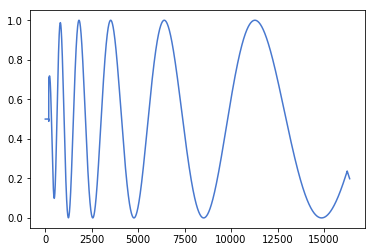

In [33]:
plt.plot(pf[1])